In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from datetime import datetime

In [2]:
customers_df = pd.read_csv(r'C:\Users\admin\Desktop\New folder (2)\Customers.csv')
products_df = pd.read_csv(r'C:\Users\admin\Desktop\New folder (2)\Products.csv')
transactions_df = pd.read_csv(r'C:\Users\admin\Desktop\New folder (2)\Transactions.csv')

In [3]:
transactions_merged = pd.merge(transactions_df, customers_df, on='CustomerID', how='left')
transactions_merged = pd.merge(transactions_merged, products_df, on='ProductID', how='left')

In [4]:
transactions_merged['TransactionDate'] = pd.to_datetime(transactions_merged['TransactionDate'])
transactions_merged['SignupDate'] = pd.to_datetime(transactions_merged['SignupDate'])
transactions_merged['DaysSinceSignup'] = (transactions_merged['TransactionDate'] - transactions_merged['SignupDate']).dt.days

In [6]:
transactions_merged.columns

Index(['TransactionID', 'CustomerID', 'ProductID', 'TransactionDate',
       'Quantity', 'TotalValue', 'Price_x', 'CustomerName', 'Region',
       'SignupDate', 'ProductName', 'Category', 'Price_y', 'DaysSinceSignup'],
      dtype='object')

In [7]:
transactions_merged = transactions_merged.drop(columns=["Price_x"])  
transactions_merged = transactions_merged.rename(columns={"Price_y": "Price"}) 

In [8]:
customer_profile = transactions_merged.groupby('CustomerID').agg(
    total_spent=('TotalValue', 'sum'),
    num_transactions=('TransactionID', 'count'),
    avg_price=('Price', 'mean'),
    avg_quantity=('Quantity', 'mean'),
    most_recent_purchase=('TransactionDate', 'max')
).reset_index()

In [9]:
customer_profile

,CustomerID,total_spent,num_transactions,avg_price,avg_quantity,most_recent_purchase
0,C0001,3354.52,5,278.334000,2.400000,2024-11-02 17:04:16
1,C0002,1862.74,4,208.920000,2.500000,2024-12-03 01:41:41
2,C0003,2725.38,4,195.707500,3.500000,2024-08-24 18:54:04
3,C0004,5354.88,8,240.636250,2.875000,2024-12-23 14:13:52
4,C0005,2034.24,3,291.603333,2.333333,2024-11-04 00:30:22
...,...,...,...,...,...,...
194,C0196,4982.88,4,416.992500,3.000000,2024-12-15 03:43:35
195,C0197,1928.65,3,227.056667,3.000000,2024-12-27 18:20:31
196,C0198,931.83,2,239.705000,1.500000,2024-10-04 18:31:12
197,C0199,1979.28,4,250.610000,2.250000,2024-10-26 00:01:58


In [10]:
scaler = StandardScaler()
customer_profile[['total_spent', 'num_transactions', 'avg_price', 'avg_quantity']] = scaler.fit_transform(
    customer_profile[['total_spent', 'num_transactions', 'avg_price', 'avg_quantity']])

In [11]:
similarity_matrix = cosine_similarity(customer_profile[['total_spent', 'num_transactions', 'avg_price', 'avg_quantity']])

In [12]:
similarity_matrix

array([[ 1.        , -0.03790014, -0.85925516, ...,  0.68879928,
         0.50043518, -0.77588374],
       [-0.03790014,  1.        ,  0.51062281, ...,  0.64944824,
         0.82999577, -0.52006852],
       [-0.85925516,  0.51062281,  1.        , ..., -0.25238582,
         0.00619966,  0.45546378],
       ...,
       [ 0.68879928,  0.64944824, -0.25238582, ...,  1.        ,
         0.94053139, -0.85192067],
       [ 0.50043518,  0.82999577,  0.00619966, ...,  0.94053139,
         1.        , -0.80511221],
       [-0.77588374, -0.52006852,  0.45546378, ..., -0.85192067,
        -0.80511221,  1.        ]])

In [13]:
lookalike_dict = {}
for i in range(20):
    customer_id = customer_profile.iloc[i]['CustomerID']
    similarity_scores = similarity_matrix[i]
    
    # Exclude the customer itself from the results
    similarity_scores[i] = -1  # Assign a low score to exclude self-comparison
    
    # Get the top 3 most similar customers
    top_3_idx = similarity_scores.argsort()[-3:][::-1]
    top_3_customers = [(customer_profile.iloc[idx]['CustomerID'], similarity_scores[idx]) for idx in top_3_idx]
    
    lookalike_dict[customer_id] = top_3_customers

In [14]:
lookalike_df = pd.DataFrame([(key, val[0][0], val[0][1], val[1][0], val[1][1], val[2][0], val[2][1]) for key, val in lookalike_dict.items()],
                            columns=['CustomerID', 'Lookalike1_ID', 'Lookalike1_Score', 'Lookalike2_ID', 'Lookalike2_Score', 'Lookalike3_ID', 'Lookalike3_Score'])

lookalike_df.to_csv('Lookalike.csv', index=False)

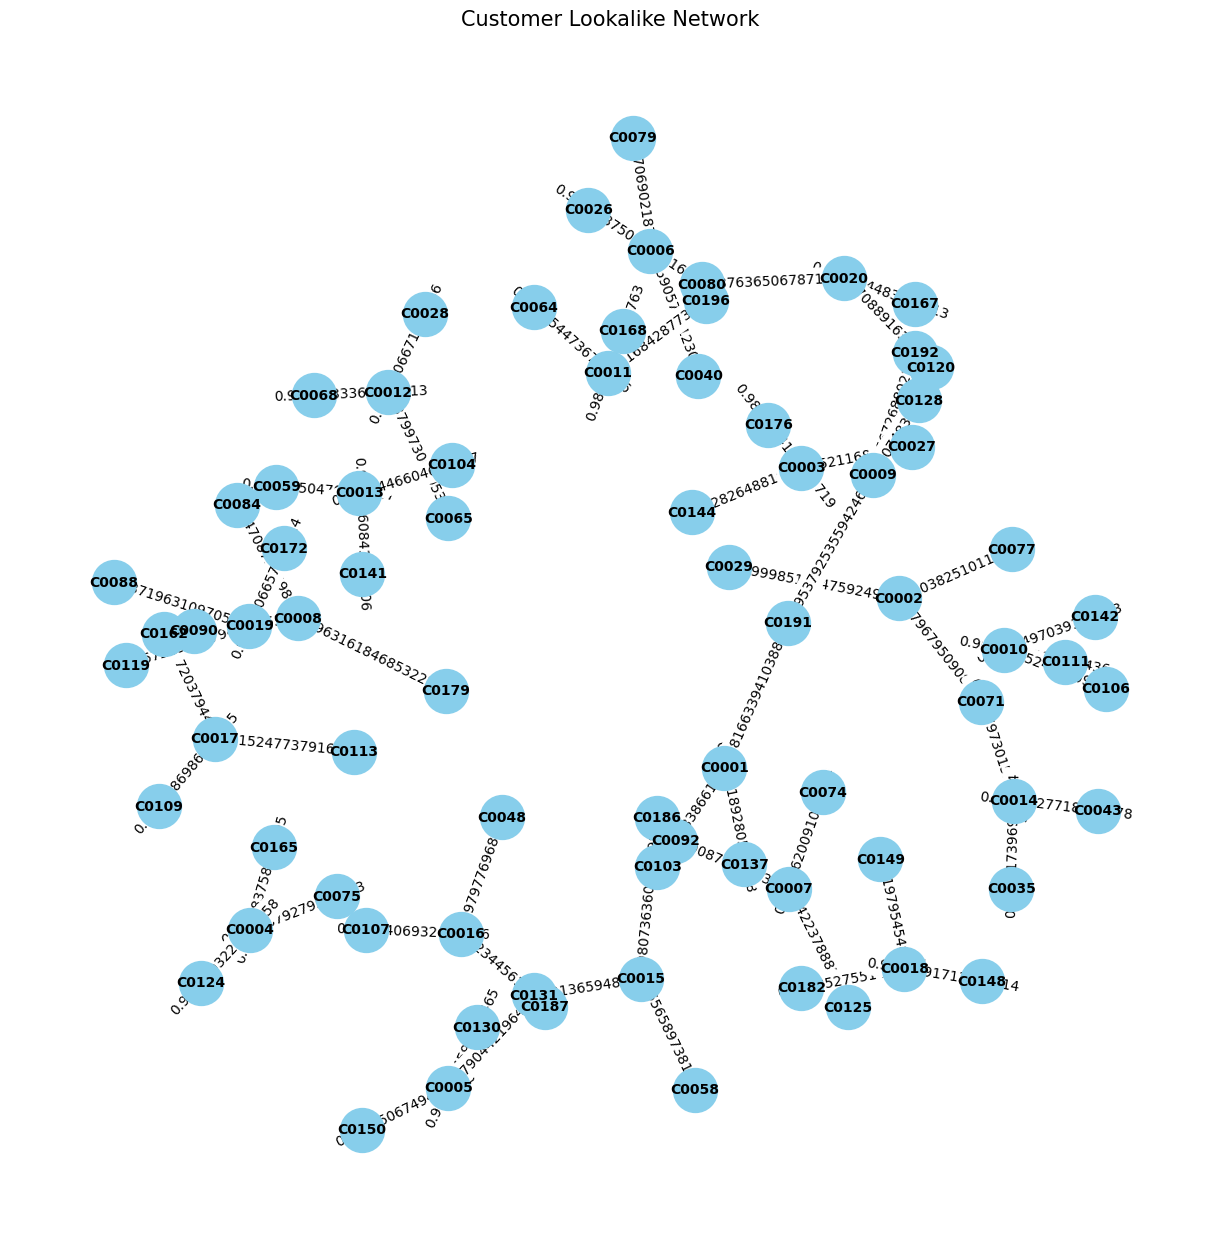

In [15]:
import networkx as nx
import matplotlib.pyplot as plt

# Initialize a graph
G = nx.Graph()

# Add nodes for each customer
for customer_id in lookalike_dict:
    G.add_node(customer_id)

# Add edges between customers and their top 3 lookalikes
for customer_id, lookalikes in lookalike_dict.items():
    for lookalike, score in lookalikes:
        G.add_edge(customer_id, lookalike, weight=score)

# Visualize the network
plt.figure(figsize=(12, 12))

# Set node positions using a layout
pos = nx.spring_layout(G, k=0.15, iterations=20)

# Draw the network graph
nx.draw(G, pos, with_labels=True, node_size=1000, node_color='skyblue', font_size=10, font_weight='bold', edge_color='gray')

# Draw edge labels for similarity scores
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

# Show plot
plt.title("Customer Lookalike Network", fontsize=15)
plt.show()
